In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models, datasets
import imageio
import time
import warnings
warnings.filterwarnings("ignore")

import random
import sys
import copy
import json
from PIL import Image

## Load dataset and preprocess

In [2]:
data_dir = "../images/flower_images/"
train_dir = data_dir + "train"
valid_dir = data_dir + "valid"

## Data transforms

In [3]:
data_transforms = {
    # augmentation
    "train": transforms.Compose([
        transforms.Resize([96, 96]),
        transforms.RandomRotation(45),
        transforms.CenterCrop(64), # crop the center of the image 64x64
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomGrayscale(p=0.025),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # mean and std
    ]),
    "valid": transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [4]:
batch_size = 128

# load data with folder index 1,2,3,...102
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) \
        for x in ['train', 'valid']
}
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) \
        for x in ['train', 'valid']
}
dataset_sizes = {
    x: len(image_datasets[x]) \
        for x in ['train', 'valid']
}
class_names = image_datasets['train'].classes

In [5]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 6552
     Root location: ../images/flower_images/train
     StandardTransform
 Transform: Compose(
                Resize(size=[96, 96], interpolation=bilinear, max_size=None, antialias=True)
                RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
                CenterCrop(size=(64, 64))
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
                RandomGrayscale(p=0.025)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 818
     Root location: ../images/flower_images/valid
     StandardTransform
 Transform: Compose(
                Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=True)


In [6]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1383afce0>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x108121f40>}

In [7]:
dataset_sizes

{'train': 6552, 'valid': 818}

In [8]:
class_names

['1',
 '10',
 '100',
 '101',
 '102',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '5',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '6',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '7',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '8',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '9',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99']

In [9]:
# id -> flower name
with open("./cat_to_name.json") as f:
    cat_to_name = json.load(f)

In [10]:
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

## Pre-trained model

In [11]:
model_name = "resnet" # resnet, alexnet, vgg, squeezenet, densenet, inception
feature_extract = True # True: 不更新

In [18]:
# check device
device = "cuda:0" if torch.cuda.is_available() else \
    "mps" if torch.backends.mps.is_available() else "cpu"
device = torch.device(device)

## Whether to update model parameters?

In [12]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [13]:
model_ft = models.resnet18()
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
for name, param in model_ft.named_parameters():
    print(name)
    # print(param)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

## Change output layer to 102 classes

In [15]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):

    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)

    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 102) # 需要反向传播的

    input_size = 64

    return model_ft, input_size

In [19]:
model_ft, input_size = initialize_model(
    model_name,
    102,
    feature_extract,
    use_pretrained=True,
)

# to device
model_ft = model_ft.to(device)

# save file
filename = "checkpoint.pt"

# params
params_to_update = model_ft.parameters()

print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t", name)

Params to learn:
	 fc.weight
	 fc.bias


In [20]:
# only the output layer needs grad

model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Optimizer settings

In [21]:
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)
# scheduler: 学习率衰减
scheduler = optim.lr_scheduler.StepLR(
    optimizer_ft,
    step_size=10,
    gamma=0.1
)
# 交叉熵损失函数
criterion = nn.CrossEntropyLoss()

## Train model

In [24]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, filename="checkpoint.pt"):
    # record time
    since = time.time()
    # record the accuracy of best model
    best_acc = 0
    # model to device
    model = model.to(device).to(torch.float32)

    train_acc_history = []
    valid_acc_history = []
    train_losses = []
    valid_losses = []

    LRs = [
        optimizer.param_groups[0]['lr']
    ]

    best_model_wts = copy.deepcopy(model.state_dict())
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # iterate over data: e.g., 1 epoch = 200 iterations
            for inputs, labels in dataloaders[phase]:
                # data to device
                inputs = inputs.to(device).float()
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                outputs = model(inputs)
                loss = criterion(outputs, labels.to(torch.float32))
                _, preds = torch.max(outputs, 1)

                # traing & update weights
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)

            # one epoch finished
            time_elapsed = time.time() - since
            print("Time elapsed: {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                    "state_dict": model.state_dict(),
                    "best_acc": best_acc,
                    "optimizer": optimizer.state_dict(),
                }
                torch.save(state, filename)

            if phase == 'valid':
                valid_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)

        # 结束一个epoch
        print("Optimizer learning rate: {:.7f}".format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])

        # 10个step 后学习率衰减
        scheduler.step() # 学习率衰减

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, valid_acc_history, train_losses, valid_losses, LRs


## Start training

In [25]:
(
    model_ft,
    valid_acc_history,
    train_acc_history,
    valid_losses,
    train_losses,
    LRs
) = train_model(
    model_ft,
    dataloaders,
    criterion,
    optimizer_ft,
    num_epochs=20,
    filename="checkpoint.pt"
)

Epoch 0/19
----------
Time elapsed: 0m 17s
train Loss: 2.9125 Acc: 0.3845
Time elapsed: 0m 19s
valid Loss: 3.5533 Acc: 0.2971
Optimizer learning rate: 0.0100000
Epoch 1/19
----------
Time elapsed: 0m 35s
train Loss: 2.7315 Acc: 0.4309
Time elapsed: 0m 36s
valid Loss: 3.6833 Acc: 0.2836
Optimizer learning rate: 0.0100000
Epoch 2/19
----------
Time elapsed: 0m 52s
train Loss: 2.7880 Acc: 0.4333
Time elapsed: 0m 54s
valid Loss: 3.6606 Acc: 0.3386
Optimizer learning rate: 0.0100000
Epoch 3/19
----------
Time elapsed: 1m 10s
train Loss: 2.7998 Acc: 0.4362
Time elapsed: 1m 12s
valid Loss: 3.8070 Acc: 0.3411
Optimizer learning rate: 0.0100000
Epoch 4/19
----------
Time elapsed: 1m 29s
train Loss: 2.7618 Acc: 0.4516
Time elapsed: 1m 31s
valid Loss: 3.8092 Acc: 0.3472
Optimizer learning rate: 0.0100000
Epoch 5/19
----------
Time elapsed: 1m 47s
train Loss: 2.9270 Acc: 0.4444
Time elapsed: 1m 49s
valid Loss: 3.9426 Acc: 0.3411
Optimizer learning rate: 0.0100000
Epoch 6/19
----------
Time elapsed

## Train all the layers

In [26]:
for param in model_ft.parameters():
    param.requires_grad = True

# all params to be trained
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-3)
# scheduler: 学习率衰减
scheduler = optim.lr_scheduler.StepLR(
    optimizer_ft,
    step_size=7,
    gamma=0.1
)
# 交叉熵损失函数
criterion = nn.CrossEntropyLoss()

In [27]:
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [28]:
(
    model_ft,
    valid_acc_history,
    train_acc_history,
    valid_losses,
    train_losses,
    LRs
) = train_model(
    model_ft,
    dataloaders,
    criterion,
    optimizer_ft,
    num_epochs=20,
    filename="checkpoint.pt"
)

Epoch 0/19
----------
Time elapsed: 0m 22s
train Loss: 2.8196 Acc: 0.4156
Time elapsed: 0m 24s
valid Loss: 3.6283 Acc: 0.3631
Optimizer learning rate: 0.0010000
Epoch 1/19
----------
Time elapsed: 0m 42s
train Loss: 1.4990 Acc: 0.6143
Time elapsed: 0m 44s
valid Loss: 2.3826 Acc: 0.4853
Optimizer learning rate: 0.0010000
Epoch 2/19
----------
Time elapsed: 1m 2s
train Loss: 1.2675 Acc: 0.6522
Time elapsed: 1m 4s
valid Loss: 1.9261 Acc: 0.5232
Optimizer learning rate: 0.0010000
Epoch 3/19
----------
Time elapsed: 1m 22s
train Loss: 0.9884 Acc: 0.7215
Time elapsed: 1m 24s
valid Loss: 1.7443 Acc: 0.5636
Optimizer learning rate: 0.0010000
Epoch 4/19
----------
Time elapsed: 1m 42s
train Loss: 0.8256 Acc: 0.7616
Time elapsed: 1m 44s
valid Loss: 1.7846 Acc: 0.5623
Optimizer learning rate: 0.0010000
Epoch 5/19
----------
Time elapsed: 2m 1s
train Loss: 0.8598 Acc: 0.7581
Time elapsed: 2m 3s
valid Loss: 1.8674 Acc: 0.5623
Optimizer learning rate: 0.0010000
Epoch 6/19
----------
Time elapsed: 2m

## Load the best model back

In [29]:
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

## Prepare test set

In [39]:
dataiter = iter(dataloaders["valid"])
images, labels = dataiter._next_data()

model_ft.eval()
if torch.backends.mps.is_available():
    output = model_ft(images.to("mps"))
else:
    output = model_ft(images)

In [40]:
output.shape

torch.Size([128, 102])

## Get the most possible

In [42]:
_, preds_tensor = torch.max(output, 1)

preds = np.squeeze(preds_tensor.cpu().numpy())

preds

array([ 36,  89,  59,  76,  83,  91,   4,  48,  90,  54,  81, 100,  77,
        53,  30,  72,  16,  53,  53,  51,   2,  30,  31,  46,  54,  23,
        63,  70,  94,  34,  62,  48,  59,  64,  55,  92,  39,  63,  55,
        83,  95,  65,  38,  59,  83,  72,  53,  73,  23,  74,  53,  49,
        85,  49,   4,  90,  23,  50,  84,  18,  41,  72,  53,   7,  55,
        55,  74, 100,  37,  32,  20,  38,  20,  56,  82,  57,  98,  45,
        72,  99,  49,  74,  55,  56,  27,  74,  48,  49,  89,  89,  55,
        85,  49,  51,  20,  96,  75,  97,   4,  73,  14,  49,  52,  10,
        19,  49,  75,  28,  86,  33,  83,  37,  23,   9,  46,  21,  95,
        38,  43,  72,  15,  49,  84,  61,  43,  82,  53,  63])

## Result

In [ ]:
# transpose the image back to (w, h, channel)
# e.g., torch -> (channel, w, h)
# e.g., numpy -> (w, h, channel)

def im_convert(tensor):

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

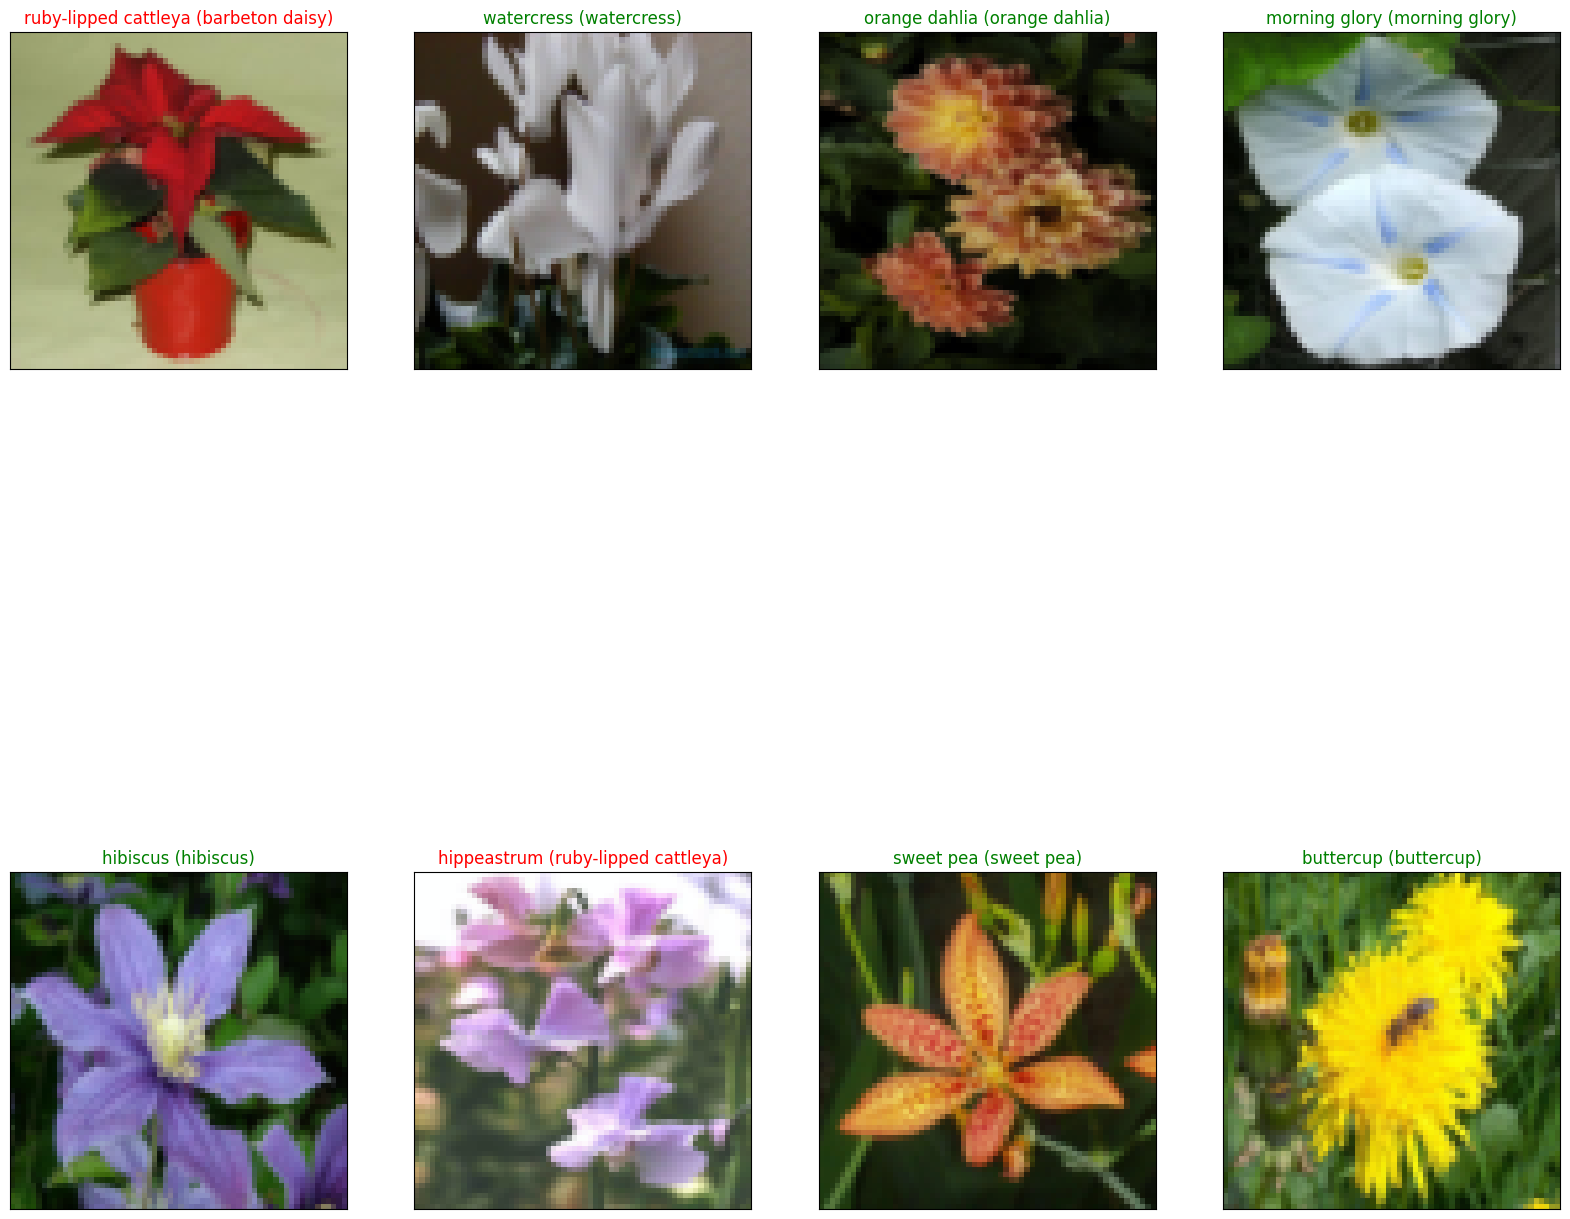

In [44]:
fig = plt.figure(figsize=(20, 20))
columns = 4
rows = 2

for idx in range(columns * rows):
    ax = fig.add_subplot(rows, columns, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(
        cat_to_name[str(preds[idx])],
        cat_to_name[str(labels[idx].item())]
    ), color=("green" if cat_to_name[str(preds[idx])] == cat_to_name[str(labels[idx].item())] else "red"))

plt.show()